# Описание задачи
## В задачи пректа входит:
- Обработка предоставленных данных: нахождение и заполнение пропусков, кодировка, нормализация признаков;
- Создание новых признаков с использованием предоставленных данных;
- Отбор признаков;
- Обучение и тестирование модели на полученных признаках;
- Оптимизация размера набора данных и подбор макропараметров модели на оптимизированном наборе;
- Получение предсказанных моделью значений, подготовка и отправка submission

## Описание датасета
Первоначальная версия датасета состоит из 14-ти столбцов, содержащих следующую информацию:

- **client_id** - идентификатор клиента
- **education** - уровень образования
- **sex** - пол заёмщика
- **age** - возраст заёмщика
- **car** - флаг наличия автомобиля
- **car**_type	флаг - автомобиля-иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия «хорошей» работы
- **bki_request_cnt** - количество запросов в БКИ
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заёмщика
- **foreign_passport** - наличие загранпаспорта
- **default** - наличие дефолта (целевая переменная)

# Импорт библиотек, установка параметров, определение функций

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, cross_validate, learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

import os

In [2]:
# функции используемые в ноутбуке
def df_describe(df):
    desc = df.describe(include='all',percentiles=[0.5]).T
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN'] = df.isna().sum()
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0] for col in  df.columns]
    return desc

def nums_visualisation(df,annotation=False):
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    if annotation: print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))

    indent = 0.05
    fig = plt.figure(figsize=(16,5))
    for i,col in enumerate(columns):
        row = df[col]
        min_diff = pd.Series(row.unique()).sort_values().diff().min()
        bins = min(int((row.max()-row.min()) / min_diff),100)
        
        fig.add_axes([1/cols_num*i, 0.35, 1/cols_num-indent, 1])
        plt.title(col)
        row.plot.hist(bins=bins,density=True)
    
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 0.2])
        sns.boxplot(x=row)

    plt.tight_layout()

def num_visualisation(row,hue): 
    row1 = row[hue==0]
    row2 = row[hue==1]
    
    min_diff = pd.Series(row.unique()).sort_values().diff().min()
    bins = min(int((row.max()-row.min()) / min_diff),100)
    bins_range = row.min()-min_diff/2 ,row.max()+min_diff/2 

    fig = plt.figure(figsize=(15,5))
    
    ax1 = fig.add_axes([0, 0.4, 1, 1])
    row1.plot.hist(bins=bins,density=True,alpha = 0.65)
    row2.plot.hist(bins=bins,density=True,alpha = 0.65)
    plt.legend(['negative','positive'])
    
    ax2 = fig.add_axes([0, 0, 1, 0.30]) 
    ax1.get_shared_x_axes().join(ax1, ax2)
    sns.boxplot(data = [row1,row2],orient='h',saturation = 0.5)

    
def cats_visualisation(df):
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    print(('Всего признаков этого типа {}. К ним относятся: ' + fstr).format(len(columns),*columns))
    
    indent = 0.05
    fig = plt.figure(figsize=(16,5))
    for i,col in enumerate(columns):
        row = df[col]
        bins = df.shape[1]
        
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 1])
        plt.title(col)
        sns.countplot(data[col])
    
def cat_visualisation(row):
    feat_name = row.name
    fig, axes = plt.subplots(1,2,figsize = (14,5))
    
    hue = data.default
    
    dist_1 = pd.DataFrame({'neg':row[hue==0].value_counts(normalize=True),
                           'pos':row[hue==1].value_counts(normalize=True)})
    ind = dist_1.index
    dist_2 = pd.DataFrame({'neg':data.groupby(feat_name).default.value_counts(normalize=True)[:,0],
                           'pos':data.groupby(feat_name).default.value_counts(normalize=True)[:,1]}).loc[ind]
    
    display(dist_2.T)
    dist_1.plot.bar(title = 'Распределение категорий '+ feat_name + '\n при разных значениях default',ax = axes[0])
    dist_2.plot.bar(title = 'Распределение default в каждой категории '+ feat_name,ax = axes[1],stacked=True)
    plt.legend(loc = 4)
    
def pre_process(df):
    label_encoder = LabelEncoder()
    scaler = MinMaxScaler()
        # scaler = StandardScaler()    
    
    num_uniq = df.nunique()
    bin_cols = df.columns[num_uniq==2]
    cat_cols = df.columns[(num_uniq>2) & (num_uniq<10)] 
    num_cols = df.columns[num_uniq>=10]
    
    # заполнение пропусков
    df.education.fillna(df.education.mode()[0],inplace=True)
    
    # обработка численных признаков
    for col in num_cols:
        df[col] = np.log(df[col]+1)
        
    df[num_cols] = scaler.fit_transform(df[num_cols].values)
    
    # обработка категориальных признаков
    df = pd.get_dummies(df,columns=cat_cols)
    
    # отбработка бинарных признаков
    for col in bin_cols:
        df[col] = label_encoder.fit_transform(df[col])
        
    return df

def validation(X,y,model):
    model = model
    cv_results = cross_validate(model, X, y, scoring='roc_auc', cv=10,)
    return cv_results['test_score'].mean()

In [3]:
# установка параметров
%pylab inline

pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

# альтернативные пути на kaggle и локальный (НЕ ЗАБЫВАТЬ МЕНЯТЬ!)
path = './Project_4_data/'
# path = '/kaggle/input/'

RANDOM_SEED = 42
model = LogisticRegression()

solvers_hyperparameters = {
    'newton-cg': {'penalty': ['l2'] , 
#                   'dual':['False']  , 
                  'tol': logspace(-8,-3,6) ,
                  'C': logspace(-3, 3, 7) , 
                  'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [100,300,600] 
                 }, 
    'lbfgs':     {'penalty': ['l2'] , 
#                   'dual':['False']  , 
                  'tol': logspace(-8,-3,6) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [100,300,600] 
                 }, 
    'liblinear': {'penalty': ['l1', 'l2'] , 
#                   'dual':['False','True']  , # True актуально только для l2 регуляризации
                  'tol': logspace(-8,-3,6) ,
                  'C': logspace(-3, 3, 7) , 
                  'intercept_scaling': [1,3,10,33,100],  
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] 
                 },
    'sag':       {'penalty': ['l2'] , 
#                   'dual':['False']  , 
                  'tol': logspace(-8,-3,6) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] ,
                  'max_iter': [100,300,600] 
                 }, 
    'saga':      {'penalty': ['l1', 'l2'] , 
#                   'dual':['False']  , 
                  'tol': logspace(-8,-3,6) ,
                  'C': logspace(-3, 3, 7) , 
                 'class_weight':  [{0:1, 1:x} for x in range(1,13,3)] 
                 }
}

Populating the interactive namespace from numpy and matplotlib


In [4]:
# проверка пути и имен файлов
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./Project_4_data/train.csv


# Ознакомление с данными

In [5]:
# чтение данных

# df_train = pd.read_csv(f'{path}main_task.csv')
# df_test = pd.read_csv(f'{path}kaggle_task.csv')
# sample_submission = pd.read_csv(f'{path}sample_submission.csv')

data = pd.read_csv(f'{path}train.csv')

Проверим наличие дупликатов в данных

In [6]:
data.duplicated().sum()

0

Посмотрим на краткую сводку и простую статистику о наборе данных.

In [7]:
data.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Columns: 14 entries, client_id to default
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [8]:
df_describe(data)

,count,unique,top,freq,mean,std,min,50%,max,type,NaN
client_id,73799,73799,1,1,55138,31841.9,1,55274,110147,<class 'numpy.int64'>,0
education,73492,5,SCH,38860,NaN,NaN,NaN,NaN,NaN,<class 'str'>,307
sex,73799,2,F,41562,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
age,73799,52,31,2727,39.2806,11.5204,21,37,72,<class 'numpy.int64'>,0
car,73799,2,N,49832,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
car_type,73799,2,N,59791,NaN,NaN,NaN,NaN,NaN,<class 'str'>,0
decline_app_cnt,73799,21,0,61214,0.275749,0.804272,0,0,33,<class 'numpy.int64'>,0
good_work,73799,2,0,61630,0.164894,0.371087,0,0,1,<class 'numpy.int64'>,0
bki_request_cnt,73799,38,0,19381,2.00034,2.25207,0,1,53,<class 'numpy.int64'>,0
home_address,73799,3,2,39956,1.57551,0.527631,1,2,3,<class 'numpy.int64'>,0


Как видиим 9 признаков представлены числовым типом данных, 5 строковыми величинами. Из этих 5 "строковых" признаков 4 признака бинарных, один категориальный(5 уникальных значений, одно из них NaN). В числовых признаках 5 признаков разумно отнести к численным (количество уникальных значений от 21 до 73799), два признака являются категориальными(в каждом 3 категории) и 2 признака бинарные.  

Пропуски встречаются только в одном признаке `education`. Их количество не велико и составляет менее 0,5% от количества наблюдений.  

Сравнивая количество уникальных значений **unique** и частоту  наиболее часто встречающейся категории **freq** можно заметь несбалансированность признаков по категориям. В `foreign_passport` `good_work` `decline_app_cnt` и `default` доля мажоритарной категории составляет около 6/7. Такой дисбаланс, особенно в целевой переменной `default` может создать проблемы при обучении модели. Нам придется предпринимать меры для устранения несбалансированности.

Посмотрим на сами данные

In [9]:
data.head(3)

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,home_address,work_address,income,foreign_passport,default
0,25905,SCH,M,62,Y,Y,0,0,1,1,2,18000,N,0
1,63161,SCH,F,59,N,N,0,0,3,2,3,19000,N,0
2,25887,SCH,M,25,Y,N,2,0,1,1,2,30000,Y,0


Разделим признаки на количественные `num_cols` , категориальные `cat_cols` и бинарные `bin_cols`.     
К бинарным, очевидно, отнесем признаки с двумя уникальными значениями.   
Категориальными признаками будем считать признаки с количеством уникальных значений от 3 до 9  
Порогом для количественного признака будет наличие более чем 10 уникальных значений. 

In [10]:
num_uniq = data.nunique()
bin_cols = data.columns[num_uniq==2]
cat_cols = data.columns[(num_uniq>2) & (num_uniq<10)] 
num_cols = data.columns[num_uniq>=10]

# Работа с предоставленными данными
Сначала рассмотрим существующие признаки, разделив их по типам.  
Выберем способы предобработки, извлечем по возможности из существующих признаков информацию для создания новых.  
Затем предобработаем существующие признаки согласно выбранным способам.
После этого создадим новые, при необходимости предобработаем и их тоже.
## Числовые признаки
Начнем с общего обзора, потом перейдем к каждому признаку в отдельности. Отмечу, что из рассмотрения не исключен казалось бы неинформативный признак `client_id` - поскольку признаков совсем немного, попробуем и из идентификатора извлечь информацию, а именно предположим что идентификатор отражает хронологический порядок занесения клиента в базу. Если такое предположение верно - признак окажется полезным при анализе, создании новых признаков и обучении модели.

Всего признаков этого типа 5. К ним относятся: client_id, age, decline_app_cnt, bki_request_cnt, income


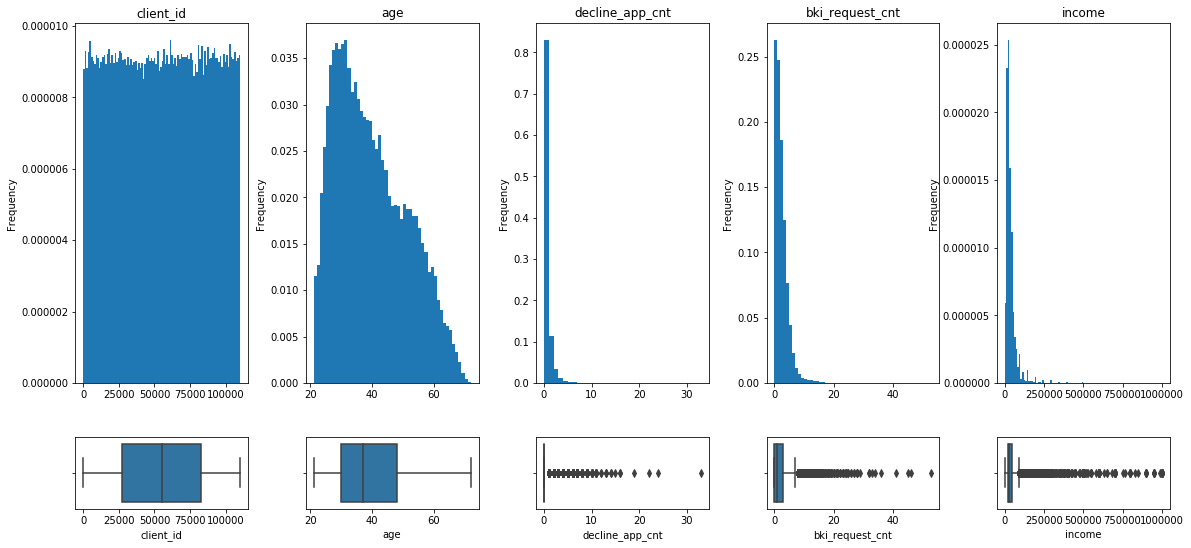

In [11]:
nums_visualisation(data[num_cols], annotation=True)

Как видим, кроме признака `client_id` числовые признаки имеют сильно скошенное вправо распределение. Такая ассиметрия будет мешать линейной модели. Применим логарифмирование: 

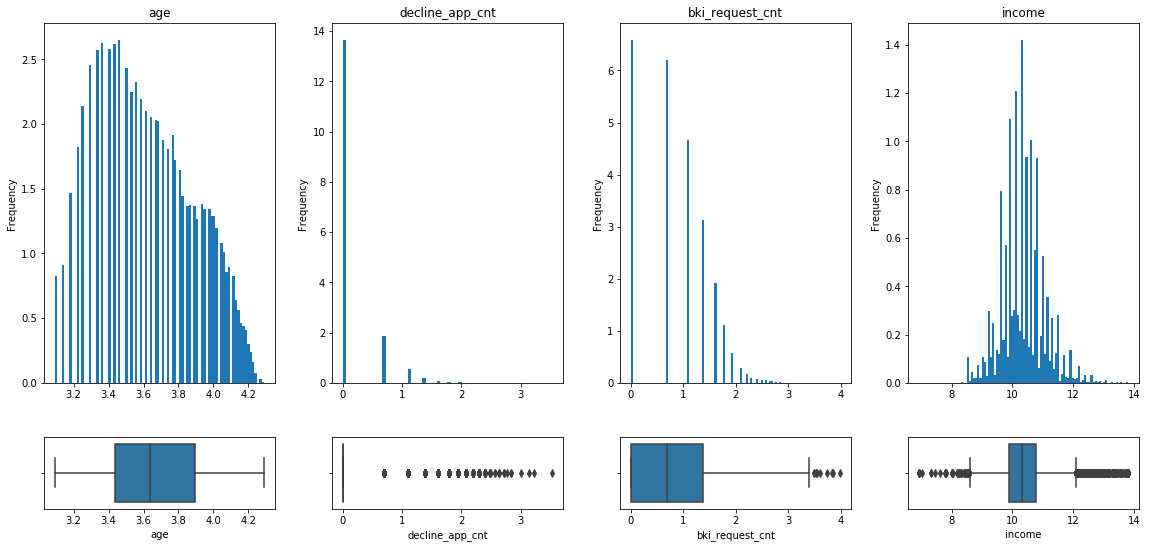

In [12]:
nums_visualisation(np.log(data[num_cols.drop('client_id')]+1))

Ситуация улучшилась: логарифмированные `age` и `income` рапсределены похоже на нормально, а в `decline_app_cnt` и `bki_request_cnt` скошенность, судя по boxplot-ам существенно уменьшилась.

Рассмотрим теперь числовые признаки по отдельности. Логарифмируемые признаки будем анализировать сразу с учетом преобразования.

### Age

Посмториим на распределения отдельно для позитивного и негативного класса целевоцй переменной.

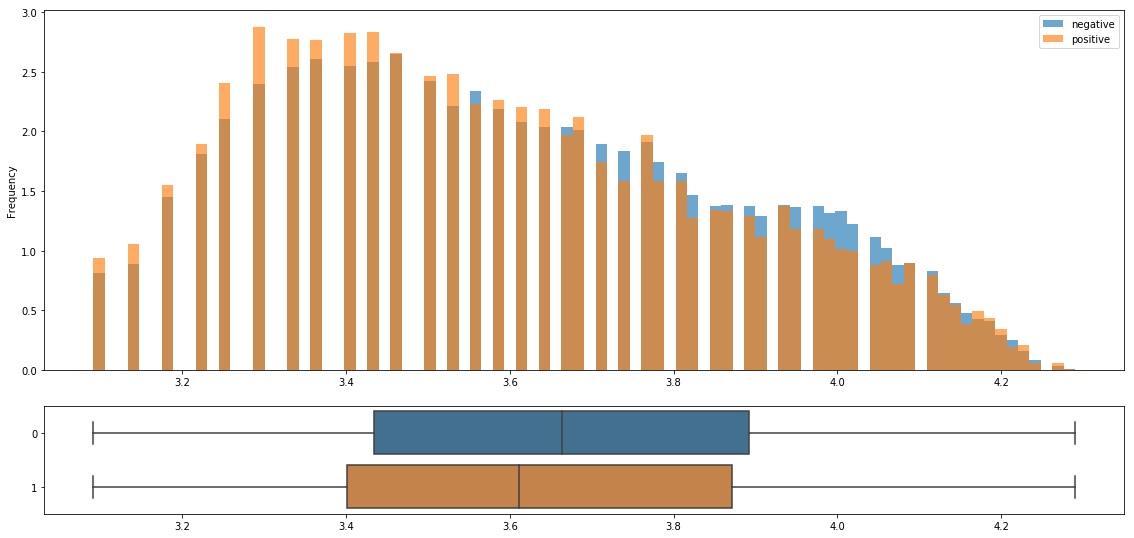

In [13]:
num_visualisation(np.log(data.age+1),data.default)

Дефолтные

### decline_app_cnt

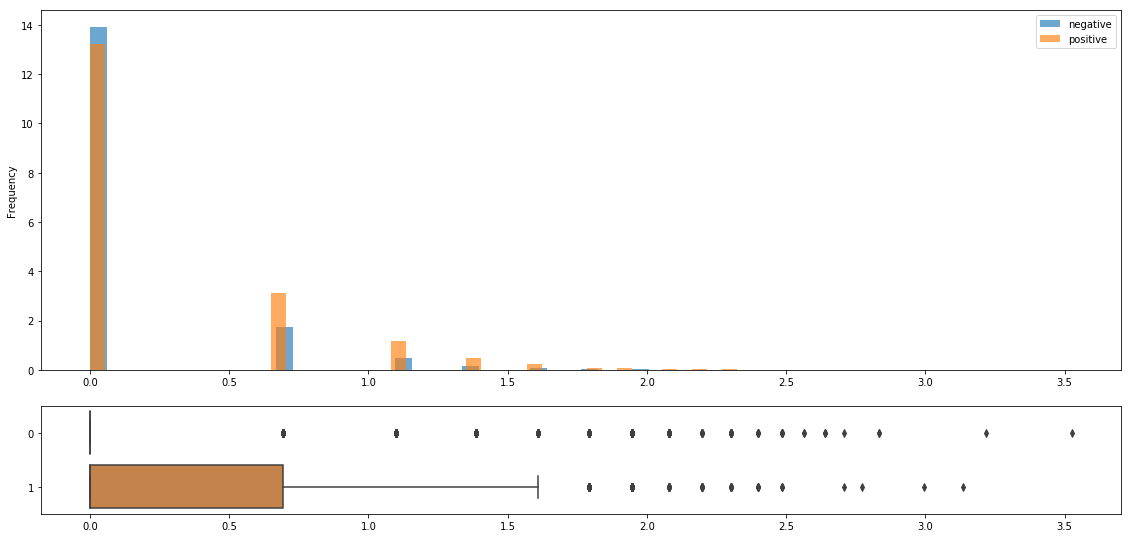

In [14]:
num_visualisation(np.log(data.decline_app_cnt+1),data.default)

текст

### bki_request_cnt

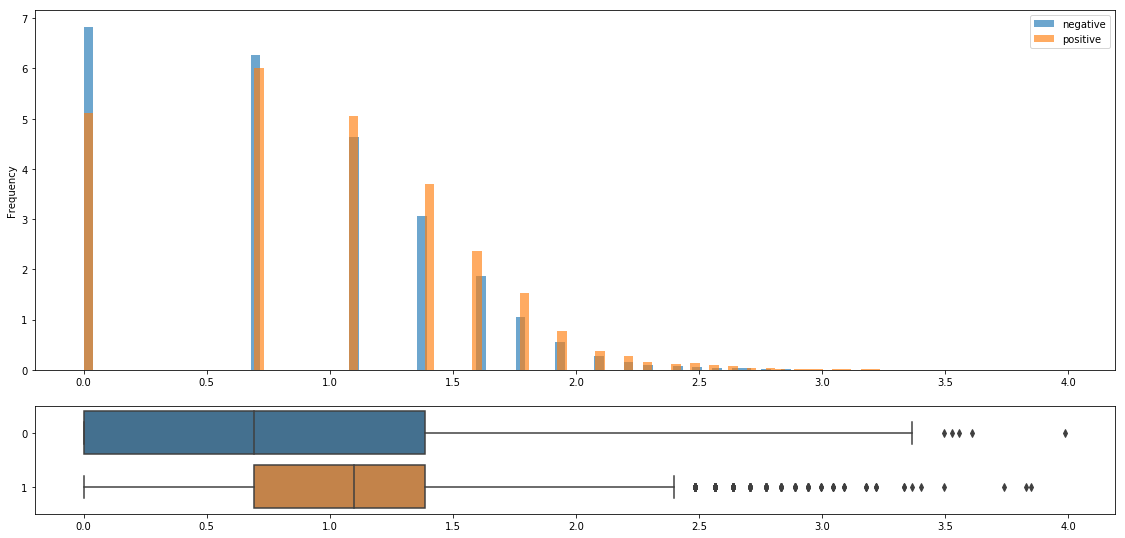

In [15]:
num_visualisation(np.log(data.bki_request_cnt+1),data.default)

Распределение Пуассона?

### income

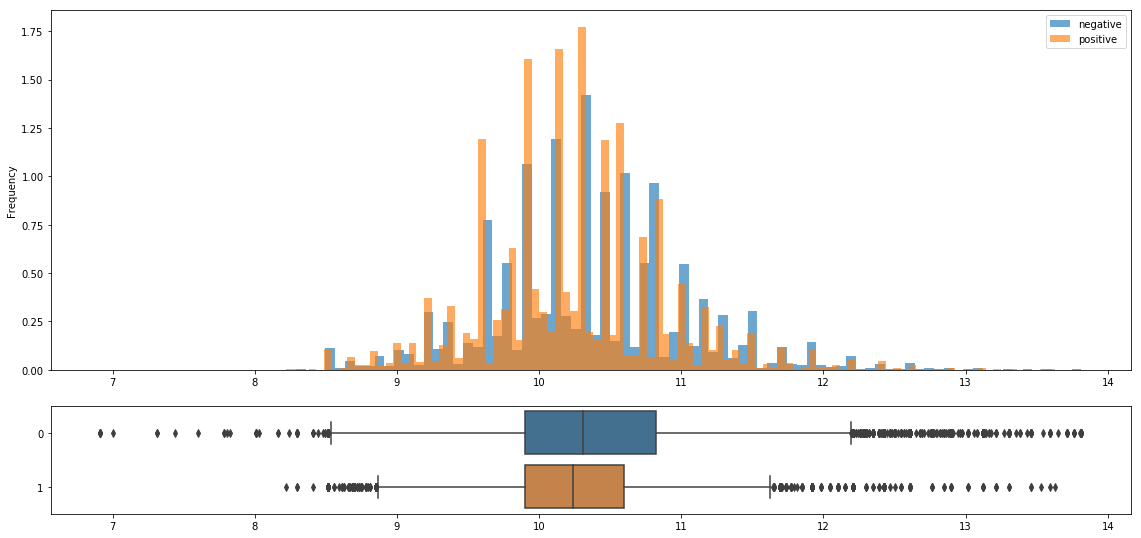

In [16]:
num_visualisation(np.log(data.income+1),data.default)

текст

### client_id

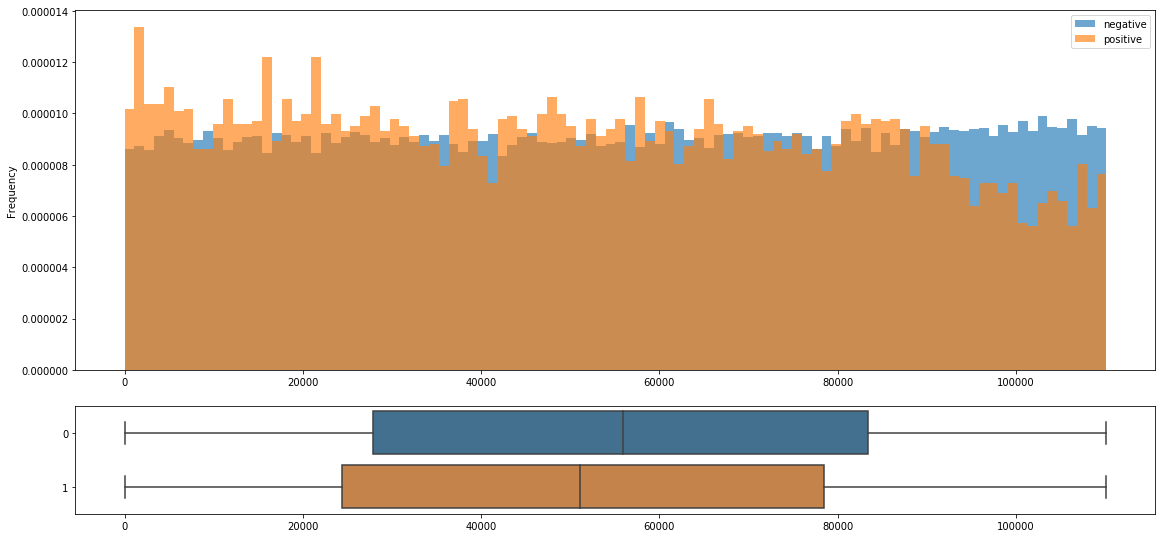

In [17]:
num_visualisation(data.client_id,data.default)

Текст

## Категориальные признаки
Посмотрим на распределение по категориям в каждом признаке:

Всего признаков этого типа 3. К ним относятся: education, home_address, work_address


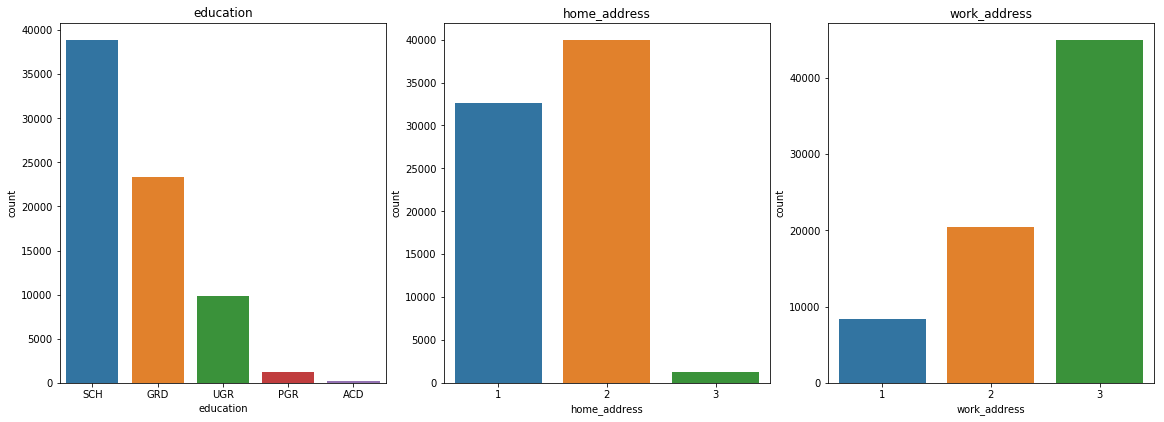

In [18]:
cats_visualisation(data[cat_cols]) 

Как видим распределение по категориям в признаках ...

  .
  .


Расссмотрим каждый признак отдельно:

### education

,SCH,GRD,UGR,PGR,ACD
neg,0.849408,0.909908,0.86848,0.935561,0.958763
pos,0.150592,0.090092,0.13152,0.064439,0.041237


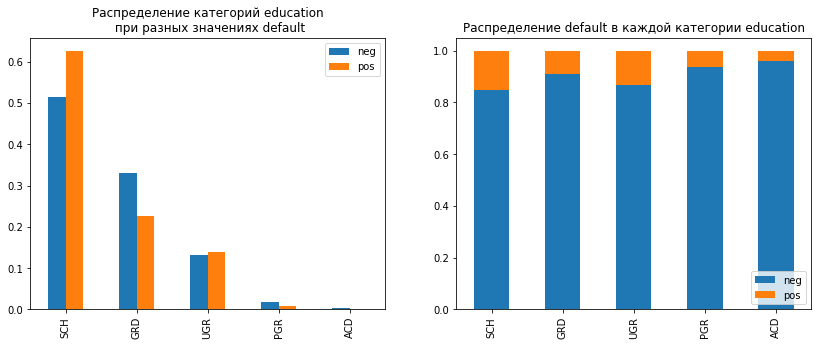

In [19]:
cat_visualisation(data.education)

### home_address

,2,1,3
neg,0.844854,0.907104,0.883943
pos,0.155146,0.092896,0.116057


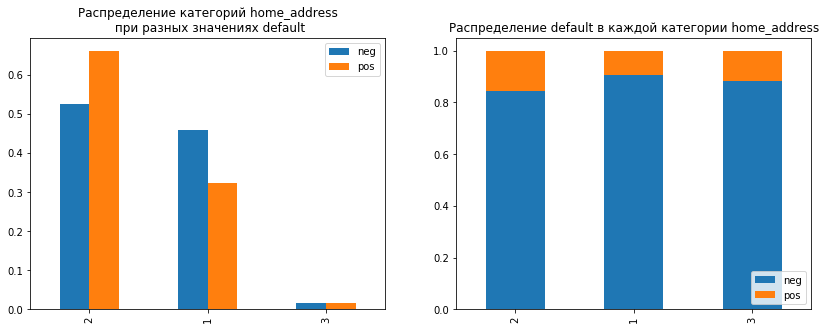

In [20]:
cat_visualisation(data.home_address)

### work_address

,3,2,1
neg,0.852043,0.897493,0.925846
pos,0.147957,0.102507,0.074154


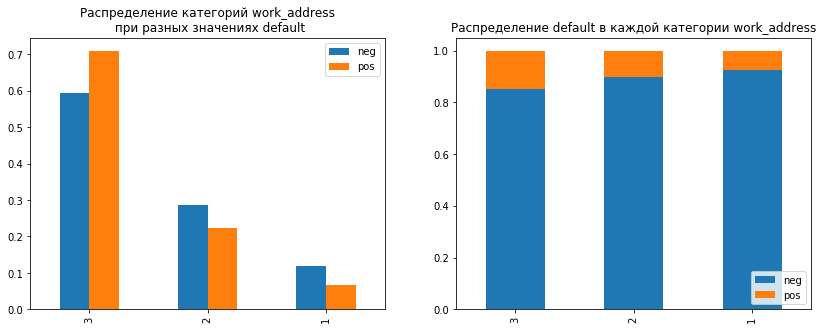

In [21]:
cat_visualisation(data.work_address)

## Бинарные признаки
Теперь рассмотрим бинарные признаки - ........

Всего признаков этого типа 6. К ним относятся: sex, car, car_type, good_work, foreign_passport, default


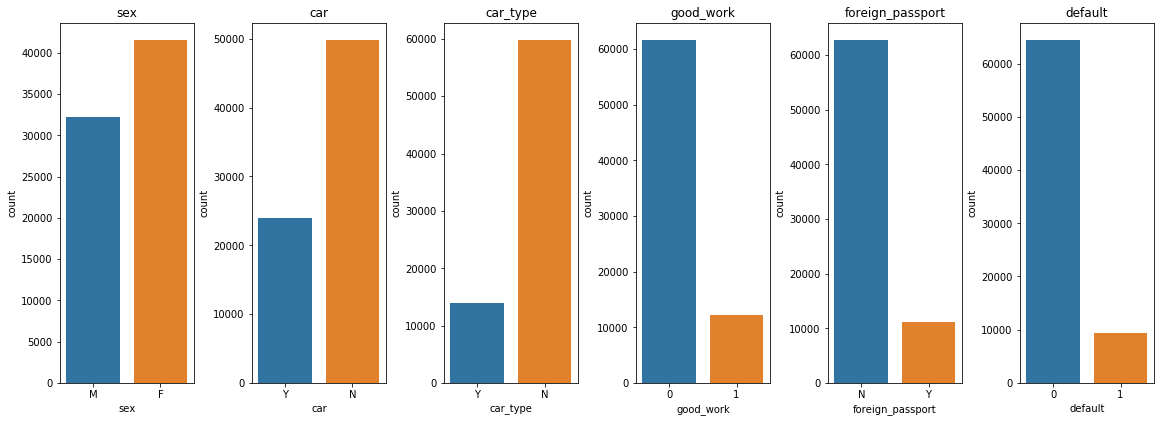

In [22]:
cats_visualisation(data[bin_cols]) 

### sex 

,F,M
neg,0.878759,0.865589
pos,0.121241,0.134411


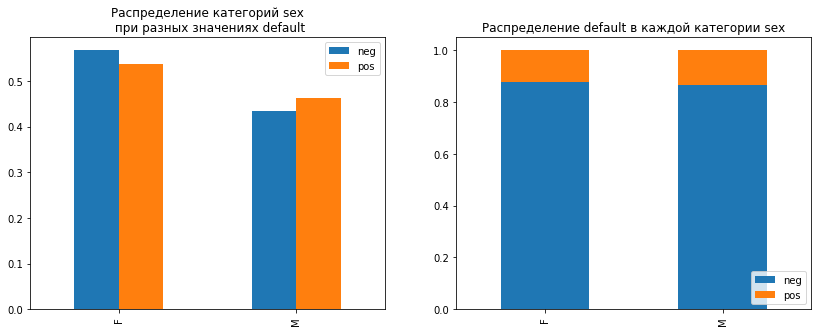

In [23]:
cat_visualisation(data.sex)

### car

,N,Y
neg,0.86304,0.893729
pos,0.13696,0.106271


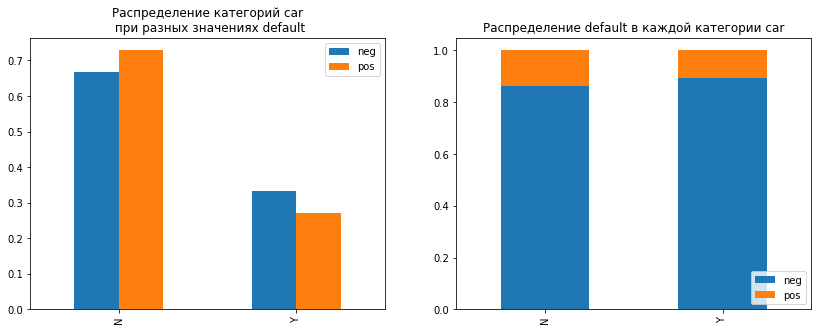

In [24]:
cat_visualisation(data.car)

### car_type

,N,Y
neg,0.863742,0.91255
pos,0.136258,0.08745


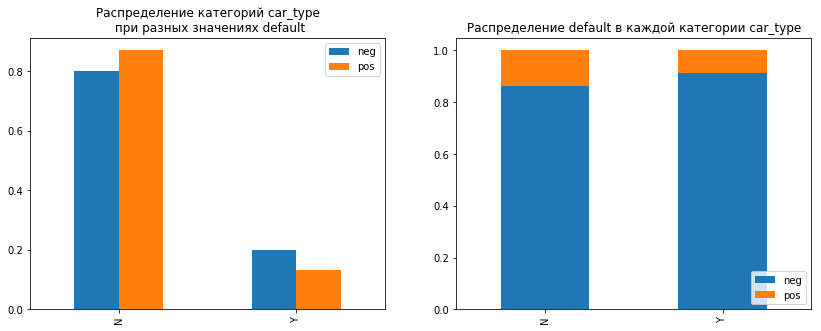

In [25]:
cat_visualisation(data.car_type)

### good_work

,0,1
neg,0.866591,0.905498
pos,0.133409,0.094502


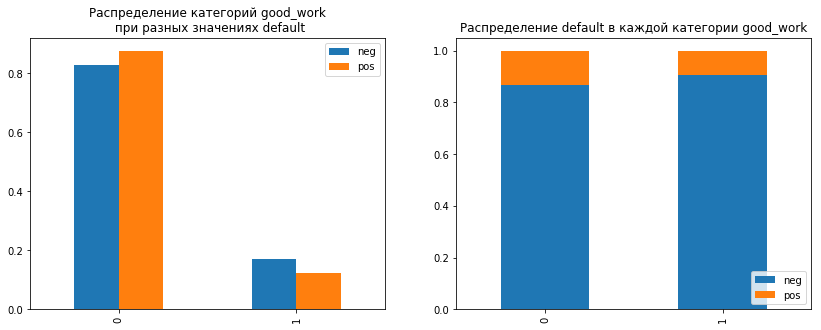

In [26]:
cat_visualisation(data.good_work)

### foreign_passport

,N,Y
neg,0.863676,0.925899
pos,0.136324,0.074101


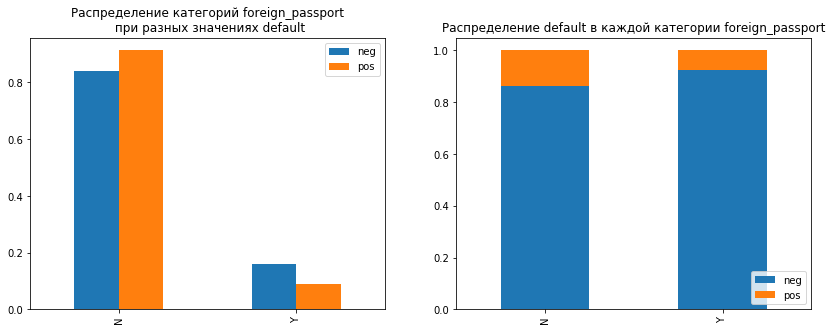

In [27]:
cat_visualisation(data.foreign_passport)

### default

# Первичная предобработка
Осуществим предобработку, согласно выбранным для каждого признака способам.

In [28]:
y = data.default
X = pre_process(data.drop(columns='default'))

# Baseline
Обучим на подготовленных данных модель LogisticRegression() спараметрами по умолчанию и получим значение метрики. Мы будем рассматривать эту модель как первую итерацию, первое приближение которое нужно улучшить.

In [29]:
validation(X, y, LogisticRegression())

0.67183689914726

# Определение оптимального размера набора данных
При подборе гиперпараметров нам предстоит многократное обучение модели на побучающей выборке. Для того чтобы оптимизировать процесс, проверим зависимость метрики о размера выборки, возможно что начиная с некоторого момента рост размера обучающей выборки перестает ощутимо влиять на качество модели и мы сможет произвести подбор гиперпараметров используя сокращенный/оптимизированный набор данных.

Получим при различных значениях взятой для обучения доли исходных данных значения метрики на тестовой выборке.

In [30]:
%%time
cv = StratifiedKFold(n_splits=5,random_state=RANDOM_SEED)

_, _, test_scores = learning_curve(
       model, X, y, train_sizes=np.linspace(.1, 1.0, 10), cv=cv, scoring = 'roc_auc')

Wall time: 11.4 s


Визуалтзируем полученный результат

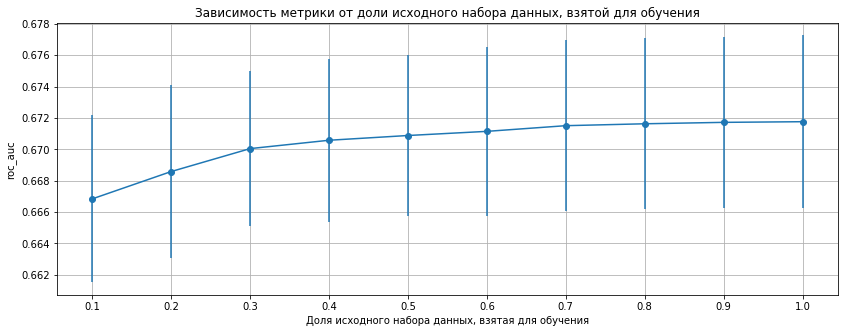

In [31]:
train_prop = np.linspace(.1, 1.0, 10)

test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure(figsize=(14,5))
plt.grid(True)
plt.xticks(train_prop)
plt.errorbar(train_prop, test_scores_mean , yerr = test_scores_std, fmt='o-')

plt.title('Зависимость метрики от доли исходного набора данных, взятой для обучения')
plt.ylabel('roc_auc')
plt.xlabel("Доля исходного набора данных, взятая для обучения");

Как видиим в рост постепенно затухает и призначениях 0.7 останавливается. Примем в качестве оптимального с точки зрения затрат времени размер данных в 0.7 от исходного количества

In [32]:
X_opt, _, y_opt, _ = train_test_split(X, y, train_size=0.7, stratify=y, random_state=RANDOM_SEED)

# Отбор признаков

In [34]:
from tqdm import tqdm
model = LogisticRegression(random_state=RANDOM_SEED)

metrics_threshold = validation(X,y,model)
unuseful_features = pd.Series([])

for col in tqdm(X.columns):
    X_tmp = X.drop(columns=col)
    metrics_tmp = validation(X_tmp,y,model)
    
    if metrics_tmp > metrics_threshold : 
        unuseful_features[col] = metrics_tmp - metrics_threshold

unuseful_features = unuseful_features.sort_values(ascending = False)

100%|██████████████████████████████████████████| 21/21 [01:33<00:00,  4.45s/it]


# Baseline + отбор признаков

In [35]:
metrics_changes = pd.Series()

for loc in tqdm(range(0,len(unuseful_features),1)):
    to_drop = unuseful_features.index[:loc] 
    X_tmp = X.drop(columns=to_drop)
    metrics_tmp = validation(X_tmp,y,model)
    metrics_changes.loc[loc] = metrics_tmp
#     print('{:3}  {:.6f}  {:.6f}'.format(loc, MAE_tmp,MAE_round_tmp))

100%|████████████████████████████████████████████| 5/5 [00:21<00:00,  4.29s/it]


In [36]:
metrics_changes.idxmax(),  metrics_changes.max()

(2, 0.6719055011984261)

# Baseline + отбор признаков + подбор гиперпараметров

In [37]:
from pprint import pprint

In [87]:
%%time

import warnings
warnings.filterwarnings("ignore")

n_iter = 10
search = pd.Series()

for solver in solvers_hyperparameters:
    hyperparameters = solvers_hyperparameters[solver]
    model = LogisticRegression(solver=solver, random_state=RANDOM_SEED)
    clf = RandomizedSearchCV(model, hyperparameters, n_iter=n_iter, scoring='roc_auc', cv=5, random_state=RANDOM_SEED)
    search[solver] = clf.fit(X_opt, y_opt)

Wall time: 1h 57min 50s


In [88]:
search.apply(lambda x: x.best_score_)

newton-cg    0.671949
lbfgs        0.671949
liblinear    0.671957
sag          0.672128
saga         0.671949
dtype: float64

In [91]:
search.sag.best_params_

{'tol': 0.001,
 'penalty': 'l2',
 'max_iter': 100,
 'class_weight': {0: 1, 1: 4},
 'C': 1000.0}

newton-cg    0.671949
lbfgs        0.671949
liblinear    0.671957
sag          0.672128
saga         0.671949
dtype: float64

{'tol': 0.001,
 'penalty': 'l2',
 'max_iter': 100,
 'class_weight': {0: 1, 1: 4},
 'C': 1000.0}

In [ ]:
tuned_solvers_hyperparameters = {}

In [ ]:
'''%%time
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

# Добавим типы регуляризации
penalty = ['l1', 'l2']
#
tol = logspace(-8,-3,num=5)
# Зададим ограничения для параметра регуляризации
C = np.logspace(-3, 3, 7)
#
fit_intercept = [True,False]
#
intercept_scaling = [1,10,30]
#
class_weight = ['balanced'] # [{0:0, 1:x} for x in range(1,13,4)]
#
solver = ['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']
#
max_iter [100,300,600]
#
warm_start = [True,False]
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty, class_weight=class_weight, 
                       solver = solver, intercept_scaling=intercept_scaling)

model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, scoring='roc_auc', cv=5, verbose=0)

best_model = clf.fit(X_opt, y_opt)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])
print('Besr score', clf.best_score_)
''';

In [ ]:
logspace(-8,-3,num=5)

# Создание новых признаков

- **client_id** - идентификатор клиента
- **education** - уровень образования
- **sex** - пол заёмщика
- **age** - возраст заёмщика
- **car** - флаг наличия автомобиля
- **car**_type	флаг - автомобиля-иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия «хорошей» работы
- **bki_request_cnt** - количество запросов в БКИ
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заёмщика
- **foreign_passport** - наличие загранпаспорта
- **default** - наличие дефолта (целевая переменная)

In [38]:
'''from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(2)
poly_features = pf.fit_transform(vis_data[['balance_due', 'payment_amount']])
poly_features
poly_features.shape'''

"from sklearn.preprocessing import PolynomialFeatures\n\npf = PolynomialFeatures(2)\npoly_features = pf.fit_transform(vis_data[['balance_due', 'payment_amount']])\npoly_features\npoly_features.shape"

In [39]:
data['bki_req_exist'] = (data.bki_request_cnt==0).astype(int)

data['claster_1'] = data.client_id.lt(10000).astype(int)
data['claster_2'] = data.client_id.between(10000,90000).astype(int)
data['claster_3'] = data.client_id.gt(90000).astype(int)

data['pry'] = np.log(data.bki_request_cnt/data.client_id +1)

data['persistence'] = np.log(data.decline_app_cnt/data.client_id +1)

# (data.bki_request_cnt/data.decline_app_cnt).value_counts(dropna=False)

data['career'] = np.log((data.income/data.age)+1)

coolness_car = np.array([2 if x=='Y' else 1  for x in data.car])
coolness_import_car = np.array([2 if x=='Y' else 1  for x in data.car_type])
coolness_pasport =  np.array([2 if x=='Y' else 1  for x in data.foreign_passport])
coolness_work = np.array([2 if x=='Y' else 1  for x in data.good_work])
data['collness'] = coolness_car*coolness_import_car*coolness_pasport*coolness_work

In [40]:
y = data.default
X_enriched = pre_process(data.drop(columns='default'))
validation(X_enriched, y, LogisticRegression())

0.6762927608550441

In [41]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(2)

In [63]:
num_uniq_enriched = data.nunique()
num_cols_enriched = data.columns[num_uniq_enriched>=10]

X_enriched_2 = pd.concat(
    [X_enriched.drop(columns=num_cols_enriched),pd.DataFrame(pf.fit_transform(X_enriched[num_cols_enriched]))],axis=1)
validation(X_enriched_2, y, LogisticRegression())

0.6771644148215692

# Повторный отбор признаков

In [43]:
from tqdm import tqdm
model = LogisticRegression(random_state=RANDOM_SEED)

metrics_threshold = validation(X_enriched,y,model)
unuseful_features = pd.Series([])

for col in tqdm(X_enriched.columns):
    X_tmp = X_enriched.drop(columns=col)
    metrics_tmp = validation(X_tmp,y,model)
    
    if metrics_tmp > metrics_threshold : 
        unuseful_features[col] = metrics_tmp - metrics_threshold

unuseful_features = unuseful_features.sort_values(ascending = False)

100%|██████████████████████████████████████████| 32/32 [03:53<00:00,  7.30s/it]


In [44]:
metrics_changes = pd.Series()

for loc in tqdm(range(0,len(unuseful_features),1)):
    to_drop = unuseful_features.index[:loc] 
    X_tmp = X_enriched.drop(columns=to_drop)
    metrics_tmp = validation(X_tmp,y,model)
    metrics_changes.loc[loc] = metrics_tmp

100%|██████████████████████████████████████████| 16/16 [01:43<00:00,  6.49s/it]


In [45]:
metrics_changes.idxmax(),  metrics_changes.max()

(3, 0.6764297276491924)

In [64]:
from tqdm import tqdm
model = LogisticRegression(random_state=RANDOM_SEED)

metrics_threshold = validation(X_enriched_2,y,model)
unuseful_features = pd.Series([])

for col in tqdm(X_enriched_2.columns):
    X_tmp = X_enriched_2.drop(columns=col)
    metrics_tmp = validation(X_tmp,y,model)
    
    if metrics_tmp > metrics_threshold : 
        unuseful_features[col] = metrics_tmp - metrics_threshold

unuseful_features = unuseful_features.sort_values(ascending = False)


 52%|█████████████████████▉                    | 36/69 [11:19<09:53, 17.98s/it]

IndexError: index 12 is out of bounds for axis 0 with size 11

In [ ]:
metrics_changes_2 = pd.Series()

for loc in tqdm(range(0,len(unuseful_features),1)):
    to_drop = unuseful_features.index[:loc] 
    X_tmp = X_enriched_2.drop(columns=to_drop)
    metrics_tmp = validation(X_tmp,y,model)
    metrics_changes_2.loc[loc] = metrics_tmp

In [ ]:
metrics_changes_2.idxmax(),  metrics_changes_2.max()

In [67]:
unuseful_features

car                 2.832445e-06
car_type            8.621444e-07
foreign_passport    2.494927e-05
bki_req_exist       4.099226e-05
education_ACD       2.354045e-05
education_GRD       1.423449e-06
education_PGR       4.818922e-06
education_SCH       3.459885e-07
education_UGR       5.234710e-06
work_address_2      3.527637e-06
collness_8          4.173024e-05
dtype: float64

# Подбор гипнерпараметров

In [68]:
X_opt, _, y_opt, _ = train_test_split(X_enriched, y, train_size=0.7, stratify=y, random_state=RANDOM_SEED)

In [69]:
%%time

import warnings
warnings.filterwarnings("ignore")

n_iter = 10
search = pd.Series()

for solver in solvers_hyperparameters:
    hyperparameters = solvers_hyperparameters[solver]
    model = LogisticRegression(solver=solver, random_state=RANDOM_SEED)
    clf = RandomizedSearchCV(model, hyperparameters, n_iter=n_iter, scoring='roc_auc', cv=5, random_state=RANDOM_SEED)
    search[solver] = clf.fit(X_opt, y_opt)

Wall time: 32min 5s


In [70]:
search.apply(lambda x: x.best_score_)

newton-cg    0.676507
lbfgs        0.676507
liblinear    0.676586
sag          0.676496
saga         0.676581
dtype: float64

In [71]:
search.sag.best_params_

{'tol': 0.001,
 'penalty': 'l2',
 'max_iter': 600,
 'class_weight': {0: 1, 1: 1},
 'C': 10.0}

# ОПЫТЫ

In [ ]:
validation(X.drop(columns='client_id'),y).mean()

## ПОДВАЛ


In [181]:
skf = StratifiedKFold(n_splits=5)


kf.split(X)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

Всего категориальных  признаков 3. К ним относятся: education, home_address, work_address


MultiIndex(levels=[['ACD', 'GRD', 'PGR', 'SCH', 'UGR'], [0, 1]],
           labels=[[0, 0, 1, 1, 2, 2, 3, 3, 4, 4], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]],
           names=['education', 'default'])

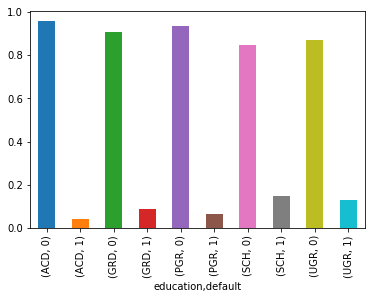

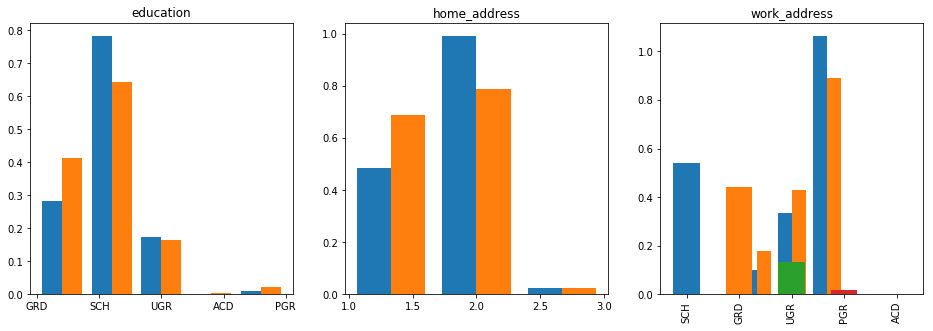

In [41]:
def num_visualisation(row):
    min_diff = pd.Series(row.unique()).sort_values().diff().min()
    bins = min(int((row.max()-row.min()) / min_diff),100)
    bins_range = row.min()-min_diff/2 ,row.max()+min_diff/2 

    fig = plt.figure()
    
    ax1 = fig.add_axes([0, 0.35, 1, 1])
    row.plot.hist(bins=bins,density=True,alpha = 0.5)
    
    ax2 = fig.add_axes([0, 0, 1, 0.2]) 
    ax1.get_shared_x_axes().join(ax1, ax2)
    sns.boxplot(x=row)
    
    plt.tight_layout()    

data.groupby('education').default.value_counts(normalize=True).plot.bar(stacked=True)

df=data[cat_cols]

if 1:
    columns = df.columns
    cols_num = df.shape[1]
    
    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    print(('Всего категориальных  признаков {}. К ним относятся: ' + fstr).format(len(columns),*columns))
    
    indent = 0.05
    fig = plt.figure(figsize=(16,5))
    for i,col in enumerate(columns):
        row = df[col]
        bins = row.nunique()
        
        plt.subplot(1,3,i+1)
        plt.title(col)
        plt.hist([data[col][data.default==1].dropna(),data[col][data.default==0].dropna()],
                 density = True, rwidth=None, bins=bins); #align = 'mid'  'left', 'mid', 'right'
        


data.home_address.value_counts(normalize=True).plot.bar()

data.education.value_counts(normalize=True).plot.bar()

aa = data.groupby('education').default.value_counts(normalize=True)
data.groupby('education').default.value_counts(normalize=True).index

## НЫЧКА

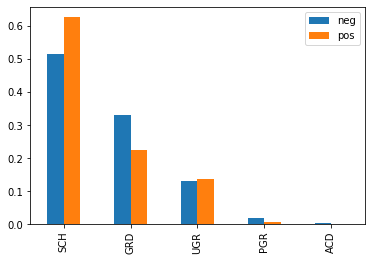

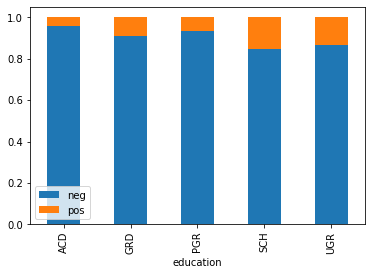

In [72]:
pd.DataFrame({'neg':data.education[data.default==0].value_counts(normalize=True),
              'pos':data.education[data.default==1].value_counts(normalize=True)}).plot.bar()

pd.DataFrame({'neg':data.groupby('education').default.value_counts(normalize=True)[:,0],
              'pos':data.groupby('education').default.value_counts(normalize=True)[:,1]}).plot.bar(stacked=True)

In [40]:
# from pprint import pprint
# pprint(aaa)

In [47]:
logspace(-8,-3,6)

array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])

In [45]:
np.logspace(-3, 3, 7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])